In [519]:
# !pip3 install gym -U  # uncomment this to run in colab

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import blackjack_double
import blackjack_reshuffle

## Часть 1

In [71]:
def basic_strategy():
    env = gym.make('Blackjack-v1', natural=True)
    my_hand, _, _ = env.reset()
    done = False
    while my_hand < 19 and not done:
        (my_hand, _, _), reward, done, _ = env.step(True)
    if not done:
        (my_hand, _, _), reward, done, _ = env.step(False)
    env.close()
    return reward

In [54]:
def average_reward(rewards):
    return [0] + [np.mean(rewards[0: i]) for i in range(1, len(rewards))]

In [81]:
def plot_results(num_hands, results):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    ax.plot(range(num_hands), results, label="Средние награды")
    ax.legend()
    ax.grid(None)
    ax.set_ylim((-0.4, 0.1))
    return fig, ax

In [69]:
def evaluate_strategy(strategy, num_hands=10000):
    rewards = []
    for i in range(num_hands):
        rewards.append(strategy())
    avg_reward = average_reward(rewards)
    print(f'Average_reward for current strategy is {avg_reward[-1]:.2f}')
    plot_results(num_hands, avg_reward)
#     plt.plot(range(num_hands), avg_reward, label="Средние награды")
    return avg_reward

Average_reward for current strategy is -0.20


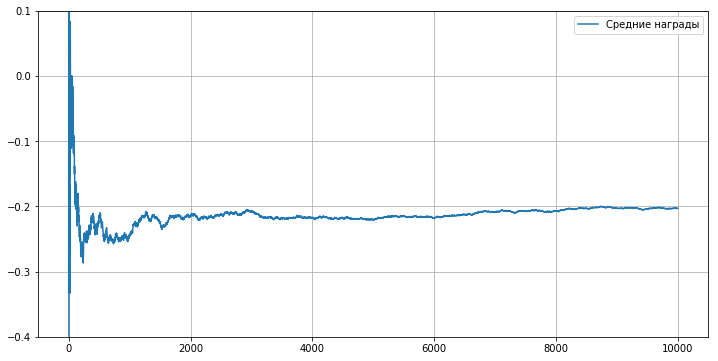

In [85]:
_ = evaluate_strategy(basic_strategy)

## Вспомогательные функции

In [5]:
class BlackjackObservationSpace():  
    # класс для удобной работы с пространством состояний
    def __init__(self, state_dim = (32, 11, 2)):  
        # размер пространства состояний в игре
        self.state_dim = state_dim
        self.state_size = np.prod(state_dim)
    
    def state_to_index(self, state):
        if np.any([state[i] >= self.state_dim[i] for i in range(len(state))]):
            return "Error! Dim is out of bounds"
        return state[0] + state[1] * self.state_dim[0] + int(state[2]) * self.state_dim[0] * self.state_dim[1]
    
    def index_to_state(self, index):
        if index >= self.state_size:
            return "Error! Index is out of bounds"
        div, state_1 = divmod(index, self.state_dim[0])
        div, state_2 = divmod(div, self.state_dim[1])
        state_3 = div % self.state_dim[2]
        return state_1, state_2, state_3

In [6]:
bos = BlackjackObservationSpace()

In [7]:
state_to_index = bos.state_to_index

In [8]:
index_to_state = bos.index_to_state

In [9]:
# small test
for i in range(1000):
    s = np.random.randint(0, 32 * 11 * 2 -1)
    if s != state_to_index(index_to_state(s)):
        print(s, i)
        break

In [2]:
class Experiment:
    # класс для проведения экспериментов. Обучение моделей осуществляется через функцию train в классе модели
    def __init__(
            self, strategy,
            env=gym.make('Blackjack-v1', natural=True),
            manual_env=False,
            num_experiments=10,
            num_experiments_pi=50,
            init_episodes=100,
            total_episodes=100,
    ):
        self.strategy = strategy
        self.env = env
        self.manual_env = manual_env
        self.num_experiments = num_experiments
        self.num_experiments_pi = num_experiments_pi
        self.init_episodes = init_episodes
        self.total_episodes = total_episodes
        self.Q_arr = [self.get_random_Q() for _ in range(num_experiments)]
        self.pi_arr = None
        self.update_pi()

    def get_random_Q(self):
        return np.random.random(size=(self.strategy.state_dim, self.strategy.action_dim))
    
    def get_obs(self):
        if self.manual_env:
            return self.env._get_obs()
        return self.env.env._get_obs()
    
    def train(self, **kwargs):
        results_learn = []
        
        for n in range(1, self.total_episodes + 1):
            for i in range(self.num_experiments):
                self.strategy.train(self.Q_arr[i], self.pi_arr[i], **kwargs)
            self.update_pi()
            result = [self.conduct_experiments_pi(pi, num_experiments=self.num_experiments_pi) for pi in self.pi_arr]
            results_learn.append(result)
        return results_learn
    
    def update_pi(self):
        self.pi_arr = [np.argmax(Q, axis=1) for Q in self.Q_arr]

    def conduct_experiments_pi(self, pi, num_experiments):
        total_reward = []
        reward = 0

        for _ in range(num_experiments):
            self.env.reset()
            done = False

            while not done:
                s = state_to_index(self.get_obs())
                observation, reward, done, _ = self.env.step(bool(pi[s]))
            total_reward.append(reward)

        self.env.close()
        return np.mean(total_reward)

In [3]:
def plot_results(results, total_episodes, step=100):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.grid(None)

    avg_results = np.mean( np.array(results), axis=1)

    ax.plot(np.arange(1, total_episodes+1, step), np.mean(avg_results.reshape(-1, step), axis=1), label="Средний результат стратегии в Q-обучении", color="C2")

    # ax.legend(lines, labels, loc="upper left")
    ax.set_xlim((1, total_episodes))
    ax.set_xlabel("Эпизоды");
    print(f"Mean score for last 10% of episodes: {np.mean(results[-total_episodes // 10:]):.4f}")

## TD-обучение: off-policy (Q-обучение)

In [10]:
class QLearning:
    def __init__(self, env=gym.make('Blackjack-v1', natural=True), manual_env=False, state_dim=bos.state_size, action_dim=2):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_options = list(range(action_dim))
        self.env = env
        self.manual_env = manual_env
    
    def get_obs(self):
        if self.manual_env:
            return self.env._get_obs()
        return self.env.env._get_obs()
    
    def train(self, Q, pi, alpha=0.1, eps=0.1, gamma=0.9, **kwargs):
        self.env.reset()
        s = state_to_index(self.get_obs())
        a = pi[s] if np.random.rand() > eps else np.random.choice(self.action_options)
        done = False

        while not done:
            observation, reward, done, _ = self.env.step(bool(a))
            observation = state_to_index(observation)
            s_prime, a_prime = (observation, pi[observation]
            if np.random.rand() > eps else np.random.choice(self.action_options))
            Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max(Q[s_prime]) - Q[s][a])
            s, a = s_prime, a_prime

In [701]:
# Протестируем, как хорошо работают стратегии и как быстро учатся
num_experiments = 10
num_experiments_pi = 50
total_episodes = 100000

experiment_q = Experiment(QLearning(),
                          num_experiments=num_experiments,
                          num_experiments_pi=num_experiments_pi,
                          total_episodes=total_episodes,
                          )

In [605]:
%%time
results_q = experiment_q.train(alpha=0.1, gamma=0.9, eps=0.1)

Wall time: 41min 10s


In [768]:
total_episodes = 100000

Mean score for last 10% of episodes: -0.1653


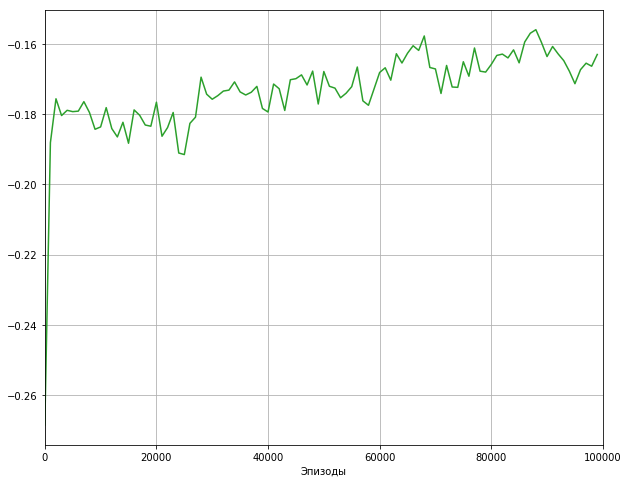

In [769]:
plot_results(results_q, total_episodes, step=1000)

## Monte-Carlo control с on-policy исследованием

In [11]:
class MonteCarlo:
    def __init__(self, env=gym.make('Blackjack-v1', natural=True), manual_env=False, state_dim=bos.state_size, action_dim=2,
                 compute_R_all=False):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_options = list(range(action_dim))
        self.env = env
        self.manual_env = manual_env
        self.N = defaultdict(lambda: defaultdict(int))
        self.R = defaultdict(lambda: defaultdict(float))
        self.states = []
        self.actions = []
        self.rewards = []
        self.compute_R_all = compute_R_all
        self.episode = []
    
    def get_obs(self):
        if self.manual_env:
            return self.env._get_obs()
        return self.env.env._get_obs()
     
    def train(self, Q, pi, eps=0.1, gamma=0.9, **kwargs):
        self.env.reset()
        s = state_to_index(self.get_obs())
        next_action = pi[s] if np.random.rand() > eps else np.random.choice(self.action_options)
        self.states.append(state_to_index(self.get_obs()))
        self.actions.append(next_action)
        self.rewards.append(0)
        done = False
        self.episode = []

        while not done:
            observation, reward, done, _ = self.env.step(bool(next_action))
            self.states.append(state_to_index(observation))
            s = state_to_index(self.get_obs())
            next_action = pi[s] if np.random.rand() > eps else np.random.choice(self.action_options)
            self.actions.append(next_action)
            self.rewards.append(reward)
            self.episode.append((s, next_action, reward))

        g = 0

        for s, a, r in self.episode[::-1]:
            g = g * gamma + r
            self.N[s][a] += 1
            Q[s][a] = (Q[s][a] * (self.N[s][a] - 1) + g) / self.N[s][a]
        pi = np.argmax(Q, axis=1)

In [24]:
num_experiments = 10
num_experiments_pi = 50
init_episodes = 100
total_episodes = 100000

experiment_mc = Experiment(MonteCarlo(),
                           num_experiments = num_experiments,
                           num_experiments_pi = num_experiments_pi,
                           init_episodes = init_episodes,
                           total_episodes = total_episodes,
                          )

In [608]:
%%time
results_mc = experiment_mc.train(gamma = 0.9, eps = 0.1)

Wall time: 39min 14s


Mean score for last 10% of episodes: -0.1113


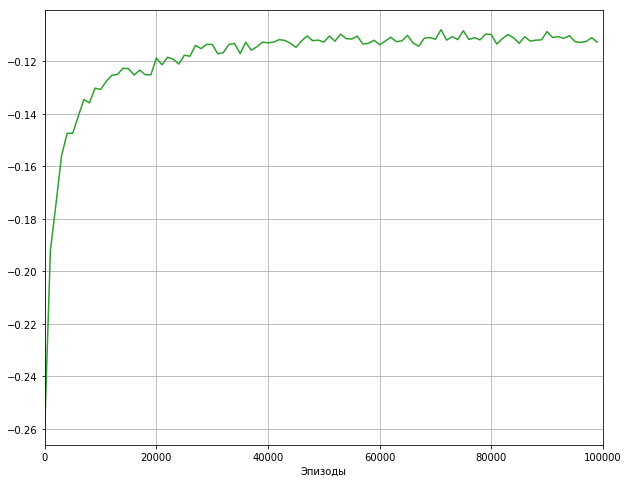

In [770]:
plot_results(results_mc, total_episodes, step=1000)

## Подбор гиперпараметров
##### MC показывает себя лучше, поэтому гиперпараметры будем подбирать у него

In [618]:
%%time
experiment_mc_1 = Experiment(MonteCarlo(),
                           num_experiments = num_experiments,
                           num_experiments_pi = num_experiments_pi,
                           init_episodes = init_episodes,
                           total_episodes = total_episodes,
                          )
results_mc_1 = experiment_mc_1.train(gamma = 0.95, eps = 0.1)

Wall time: 38min 31s


Mean score for last 10% of episodes: -0.1039


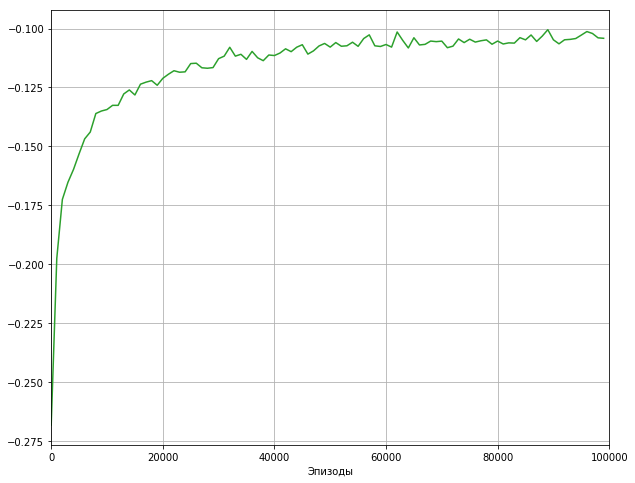

In [771]:
plot_results(results_mc_1, total_episodes, step=1000)

In [620]:
%%time
experiment_mc_2 = Experiment(MonteCarlo(),
                           num_experiments = num_experiments,
                           num_experiments_pi = num_experiments_pi,
                           init_episodes = init_episodes,
                           total_episodes = total_episodes,
                          )
results_mc_2 = experiment_mc_2.train(gamma = 0.99, eps = 0.1)

Wall time: 38min 33s


Mean score for last 10% of episodes: -0.1061


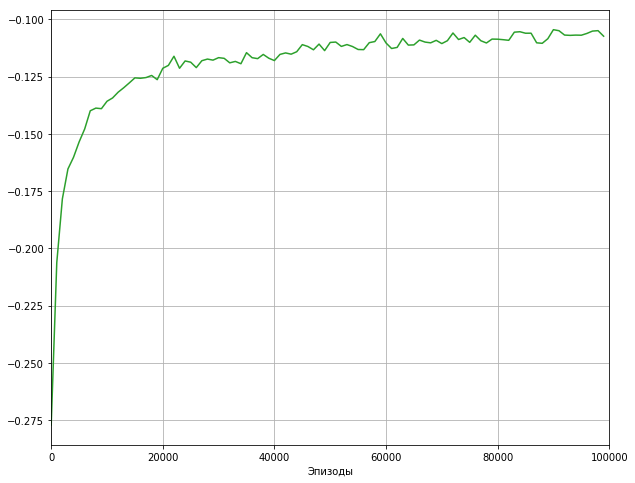

In [772]:
plot_results(results_mc_2, total_episodes, step=1000)

In [622]:
%%time
experiment_mc_3 = Experiment(MonteCarlo(),
                           num_experiments = num_experiments,
                           num_experiments_pi = num_experiments_pi,
                           init_episodes = init_episodes,
                           total_episodes = total_episodes,
                          )
results_mc_3 = experiment_mc_3.train(gamma = 0.9, eps = 0.05)

Wall time: 38min 55s


Mean score for last 10% of episodes: -0.1022


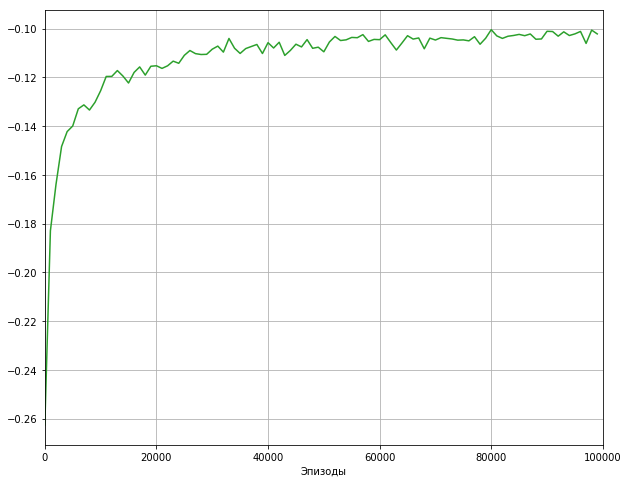

In [773]:
plot_results(results_mc_3, total_episodes, step=1000)

In [624]:
%%time
experiment_mc_4 = Experiment(MonteCarlo(),
                           num_experiments = num_experiments,
                           num_experiments_pi = num_experiments_pi,
                           init_episodes = init_episodes,
                           total_episodes = total_episodes,
                          )
results_mc_4 = experiment_mc_4.train(gamma = 0.99, eps = 0.05)

Wall time: 38min 19s


Mean score for last 10% of episodes: -0.1049


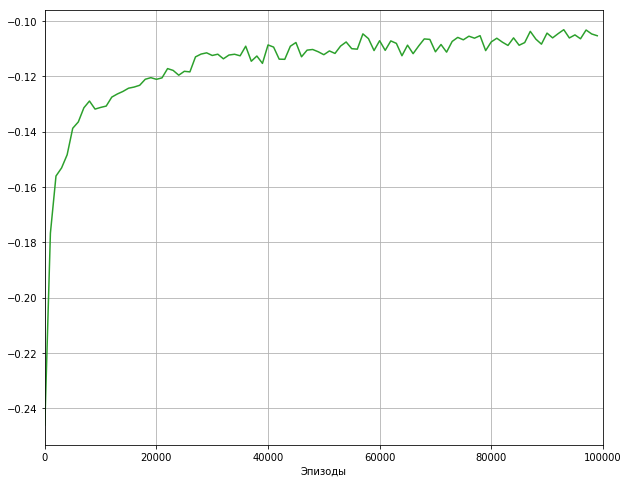

In [774]:
plot_results(results_mc_4, total_episodes, step=1000)

In [636]:
h_results = [np.mean(x[-2000:]) for x in (results_mc, results_mc_1, results_mc_2, results_mc_3, results_mc_4)]

In [674]:
print(h_results)

[-0.111845, -0.104054, -0.10615799999999999, -0.10138300000000001, -0.10496200000000001]


In [675]:
best_res = np.argmax(h_results)

In [676]:
gamma, eps = [(0.9, 0.1), (0.95, 0.1), (0.99, 0.1), (0.9, 0.05), (0.99, 0.05)][best_res]

In [677]:
gamma, eps

(0.9, 0.05)

In [775]:
total_episodes = 500000

In [641]:
%%time
experiment_mc_5 = Experiment(MonteCarlo(),
                           num_experiments = num_experiments,
                           num_experiments_pi = num_experiments_pi,
                           init_episodes = init_episodes,
                           total_episodes = total_episodes,
                          )
results_mc_5 = experiment_mc_5.train(gamma = gamma, eps = eps)

Wall time: 3h 13min 2s


Mean score for last 10% of episodes: -0.1022


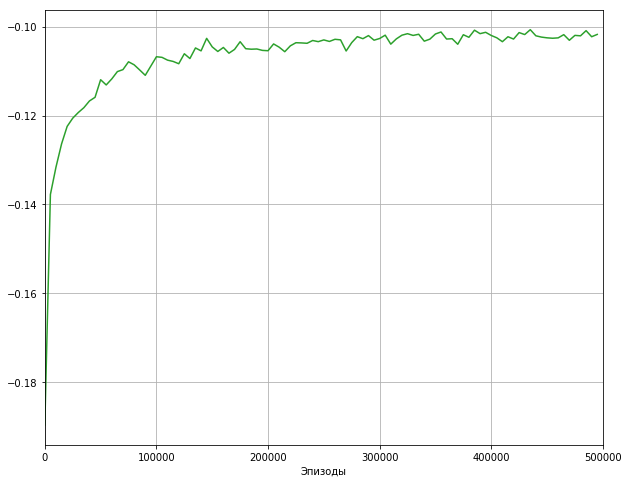

In [776]:
plot_results(results_mc_5, total_episodes, step=5000)

# Часть 2. Удвоение

## TD-обучение: off-policy (Q-обучение)

In [592]:
env_double = blackjack_double.BlackjackEnv(natural=True)

In [702]:
# Протестируем, как хорошо работают стратегии и как быстро учатся
num_experiments = 10
num_experiments_pi = 50
total_episodes = 100000

experiment_q_double = Experiment(QLearning(env=env_double, manual_env=True, action_dim=3),
                          num_experiments=num_experiments,
                          num_experiments_pi=num_experiments_pi,
                          total_episodes=total_episodes,
                          )

In [777]:
total_episodes = 100000

In [611]:
%%time
results_q_double = experiment_q_double.train(alpha=0.1, gamma=0.9, eps=0.1)

Wall time: 41min 21s


Mean score for last 10% of episodes: -0.1789


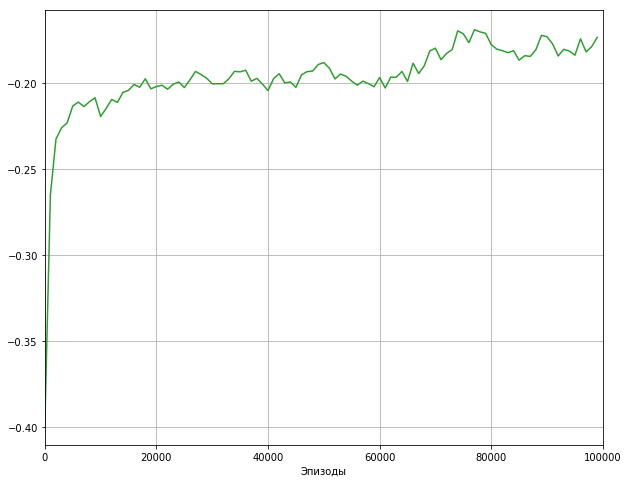

In [778]:
plot_results(results_q_double, total_episodes, step=1000)

## MC

In [613]:
num_experiments = 10
num_experiments_pi = 50
init_episodes = 1000
total_episodes = 100000

experiment_mc_double = Experiment(MonteCarlo(env=env_double, manual_env=True, action_dim=3),
                           num_experiments = num_experiments,
                           num_experiments_pi = num_experiments_pi,
                           init_episodes = init_episodes,
                           total_episodes = total_episodes,
                          )

In [614]:
%%time
results_mc_double = experiment_mc_double.train(gamma = 0.9, eps = 0.1)

Wall time: 40min 1s


Mean score for last 10% of episodes: -0.0959


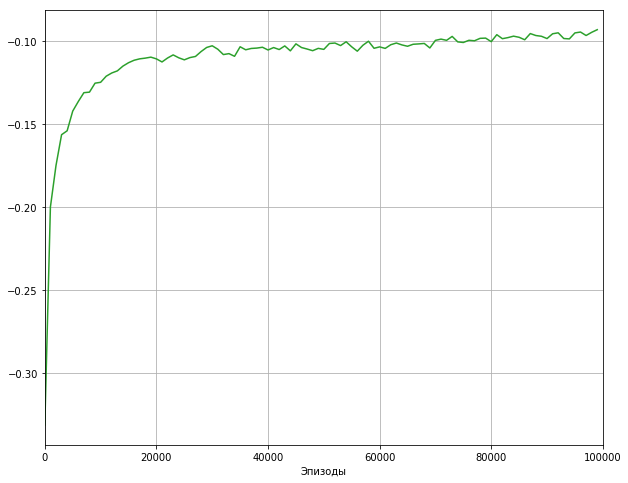

In [779]:
plot_results(results_mc_double, total_episodes, step=1000)

## Подбор гиперпараметров
##### MC показывает себя лучше, поэтому гиперпараметры будем подбирать у него

In [626]:
%%time
experiment_mc_double_1 = Experiment(MonteCarlo(env=env_double, manual_env=True, action_dim=3),
                           num_experiments = num_experiments,
                           num_experiments_pi = num_experiments_pi,
                           init_episodes = init_episodes,
                           total_episodes = total_episodes,
                          )
results_mc_double_1 = experiment_mc_double_1.train(gamma = 0.95, eps = 0.1)

Wall time: 39min 42s


Mean score for last 10% of episodes: -0.0915


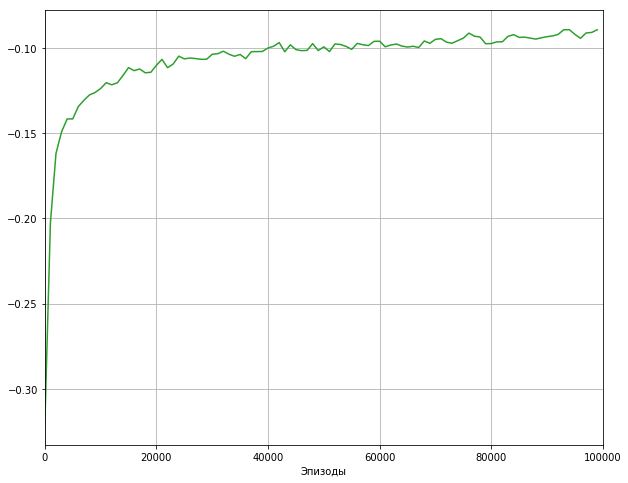

In [780]:
plot_results(results_mc_double_1, total_episodes, step=1000)

In [628]:
%%time
experiment_mc_double_2 = Experiment(MonteCarlo(env=env_double, manual_env=True, action_dim=3),
                           num_experiments = num_experiments,
                           num_experiments_pi = num_experiments_pi,
                           init_episodes = init_episodes,
                           total_episodes = total_episodes,
                          )
results_mc_double_2 = experiment_mc_double_2.train(gamma = 0.99, eps = 0.1)

Wall time: 39min 45s


Mean score for last 10% of episodes: -0.1004


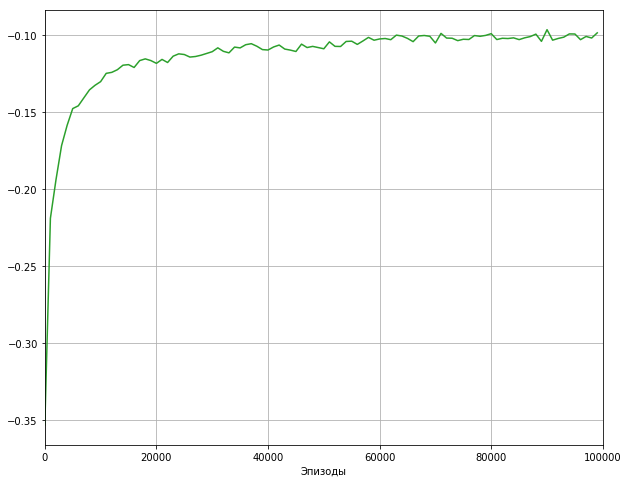

In [781]:
plot_results(results_mc_double_2, total_episodes, step=1000)

In [630]:
%%time
experiment_mc_double_3 = Experiment(MonteCarlo(env=env_double, manual_env=True, action_dim=3),
                           num_experiments = num_experiments,
                           num_experiments_pi = num_experiments_pi,
                           init_episodes = init_episodes,
                           total_episodes = total_episodes,
                          )
results_mc_double_3 = experiment_mc_double_3.train(gamma = 0.9, eps = 0.05)

Wall time: 39min 56s


Mean score for last 10% of episodes: -0.1022


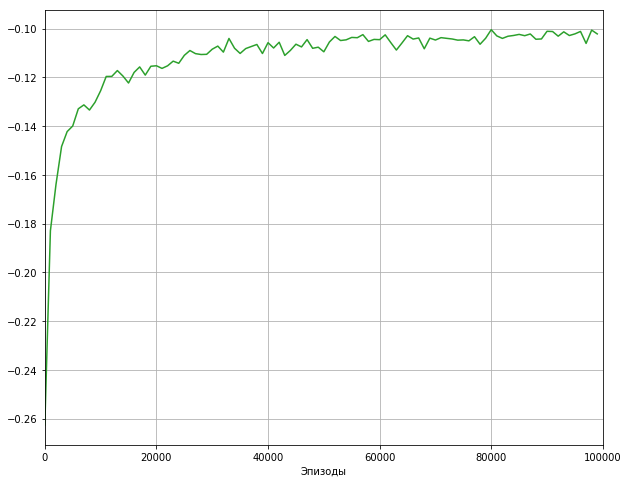

In [782]:
plot_results(results_mc_3, total_episodes, step=1000)

In [632]:
%%time
experiment_mc_double_4 = Experiment(MonteCarlo(env=env_double, manual_env=True, action_dim=3),
                           num_experiments = num_experiments,
                           num_experiments_pi = num_experiments_pi,
                           init_episodes = init_episodes,
                           total_episodes = total_episodes,
                          )
results_mc_double_4 = experiment_mc_double_4.train(gamma = 0.99, eps = 0.05)

Wall time: 39min 41s


Mean score for last 10% of episodes: -0.1049


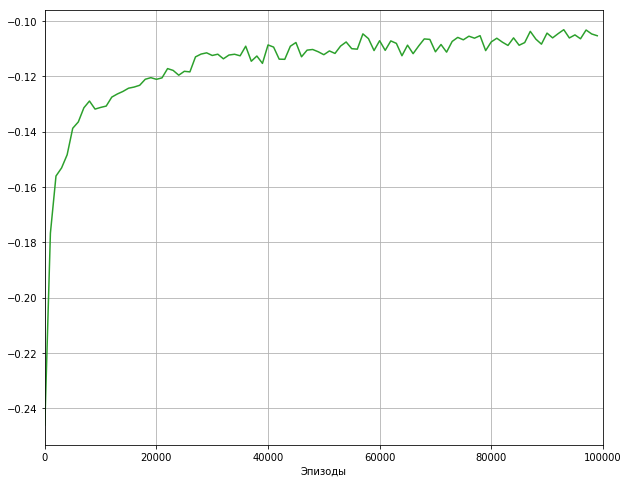

In [783]:
plot_results(results_mc_4, total_episodes, step=1000)

In [649]:
%%time
experiment_mc_double_5 = Experiment(MonteCarlo(env=env_double, manual_env=True, action_dim=3),
                           num_experiments = num_experiments,
                           num_experiments_pi = num_experiments_pi,
                           init_episodes = init_episodes,
                           total_episodes = total_episodes,
                          )
results_mc_double_5 = experiment_mc_double_5.train(gamma = 0.9, eps = 0.01)

Wall time: 39min 59s


Mean score for last 10% of episodes: -0.0882


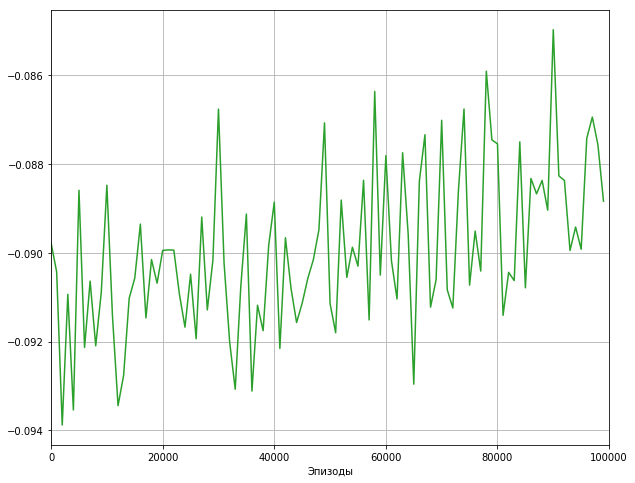

In [784]:
plot_results(results_mc_double_5, total_episodes, step=1000)

### С маленьким epsilon средний результат получился лучше, но дисперсия очень большая

### Попробуем обучить модель с лучшими гиперпараметрами на большем количестве итераций

In [785]:
total_episodes = 500000

In [740]:
gamma, eps = 0.9, 0.05

In [741]:
%%time
experiment_mc_6_double = Experiment(MonteCarlo(),
                           num_experiments = num_experiments,
                           num_experiments_pi = num_experiments_pi,
                           init_episodes = init_episodes,
                           total_episodes = total_episodes,
                          )
results_mc_6_double = experiment_mc_6_double.train(gamma = gamma, eps = eps)

Wall time: 3h 11min 54s


Mean score for last 10% of episodes: -0.1011


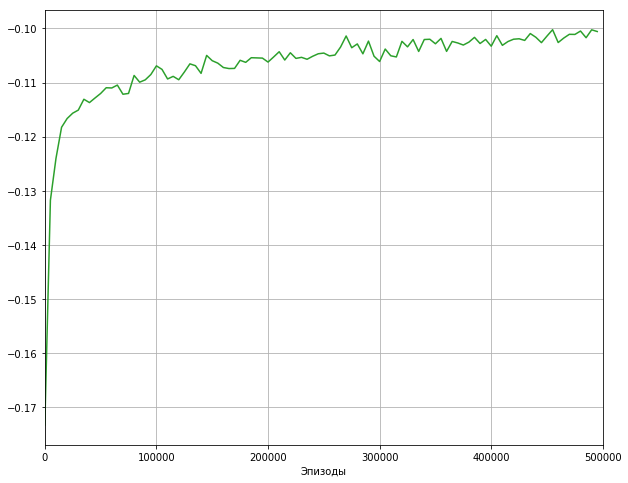

In [786]:
plot_results(results_mc_6_double, total_episodes, step=5000)

# Часть 3. Считаем карты

Поскольку вычислительные ресурсы ограничены, имеет смысл взять вариант с наименьшим пространством состояний.
Поэтому карты будем считать по системе «Плюс-минус».  

Каждой карте, выходящей из колоды, присваивается своё числовое значение:
- 2, 3, 4, 5, 6:	+1
- 7, 8, 9:	0
- 10, В, Д, К, Т:	−1

Всего количество очков в раздче может быть от -20 до +20 (4 масти по 5 очков).
т.е. пространство состояний приобретет 4 измерение (вектор длиной 41).

In [12]:
class BlackjackObservationSpace():  
    # класс для удобной работы с пространством состояний
    def __init__(self, state_dim = (32, 11, 2, 41)):  
        # размер пространства состояний в игре
        self.state_dim = state_dim
        self.state_size = np.prod(state_dim)
    
    def state_to_index(self, state):
        if np.any([state[i] >= self.state_dim[i] for i in range(len(state))]):
            return "Error! Dim is out of bounds"
        return state[0] + state[1] * self.state_dim[0] + int(state[2]) * self.state_dim[0] * self.state_dim[1]
    
    def index_to_state(self, index):
        if index >= self.state_size:
            return "Error! Index is out of bounds"
        div, state_1 = divmod(index, self.state_dim[0])
        div, state_2 = divmod(div, self.state_dim[1])
        state_3 = div % self.state_dim[2]
        return state_1, state_2, state_3

In [13]:
bos = BlackjackObservationSpace()

In [14]:
state_to_index = bos.state_to_index

In [15]:
index_to_state = bos.index_to_state

In [16]:
# small test
for i in range(1000):
    s = np.random.randint(0, 32 * 11 * 2 -1)
    if s != state_to_index(index_to_state(s)):
        print(s, i)
        break

In [17]:
bos.state_size

28864

In [18]:
env_reshuffle = blackjack_reshuffle.BlackjackEnv(natural=True)

In [30]:
# Протестируем, как хорошо работают стратегии и как быстро учатся
num_experiments = 10
num_experiments_pi = 50
total_episodes = 100000

experiment_q_reshuffle = Experiment(QLearning(env=env_reshuffle, manual_env=True, action_dim=3),
                          num_experiments=num_experiments,
                          num_experiments_pi=num_experiments_pi,
                          total_episodes=total_episodes,
                          )

In [31]:
%%time
results_q_reshuffle = experiment_q_reshuffle.train(alpha=0.1, gamma=0.9, eps=0.1)

Wall time: 40min 30s


Mean score for last 10% of episodes: -0.1770


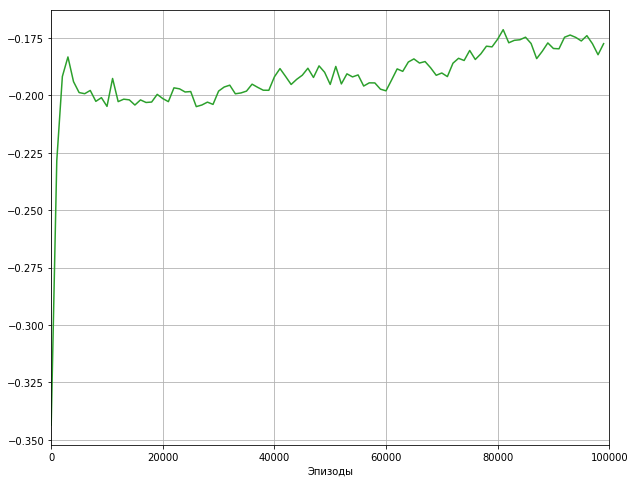

In [32]:
plot_results(results_q_reshuffle, total_episodes, step=1000)

In [33]:
%%time
experiment_mc_reshuffle_1 = Experiment(MonteCarlo(env=env_reshuffle, manual_env=True, action_dim=3),
                           num_experiments = num_experiments,
                           num_experiments_pi = num_experiments_pi,
                           init_episodes = init_episodes,
                           total_episodes = total_episodes,
                          )
results_mc_reshuffle_1 = experiment_mc_reshuffle_1.train(gamma = 0.95, eps = 0.1)

Wall time: 39min 11s


Mean score for last 10% of episodes: -0.0999


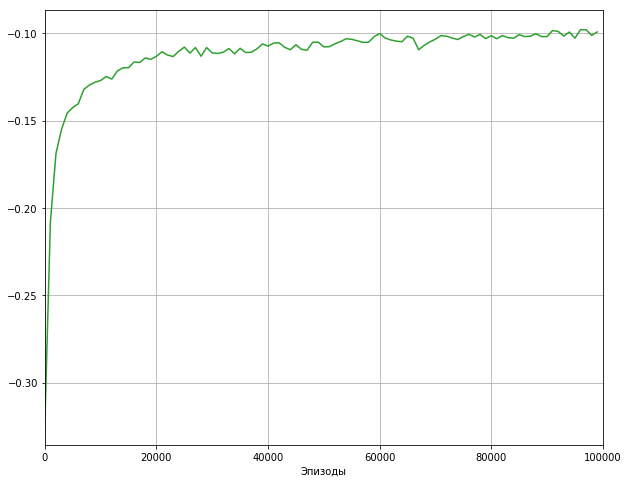

In [34]:
plot_results(results_mc_reshuffle_1, total_episodes, step=1000)

### Попробуем обучить модель с лучшими гиперпараметрами из предыдущего пункта на большем количестве итераций

In [35]:
total_episodes = 1000000

In [764]:
%%time
experiment_mc_reshuffle_2 = Experiment(MonteCarlo(env=env_reshuffle, manual_env=True, action_dim=3),
                           num_experiments = num_experiments,
                           num_experiments_pi = num_experiments_pi,
                           init_episodes = init_episodes,
                           total_episodes = total_episodes,
                          )
results_mc_reshuffle_2 = experiment_mc_reshuffle_2.train(gamma = 0.9, eps = 0.05)

Wall time: 6h 40min 46s


Mean score for last 10% of episodes: -0.0836


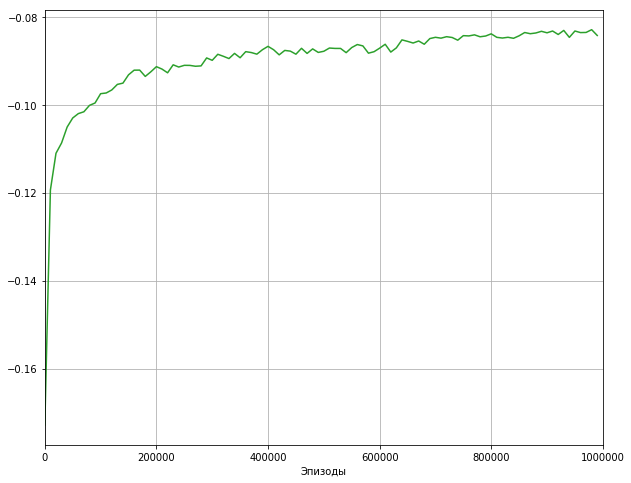

In [792]:
plot_results(results_mc_reshuffle_2, total_episodes, step=10000)

In [36]:
%%time
experiment_mc_reshuffle_3 = Experiment(MonteCarlo(env=env_reshuffle, manual_env=True, action_dim=3),
                           num_experiments = num_experiments,
                           num_experiments_pi = num_experiments_pi,
                           init_episodes = init_episodes,
                           total_episodes = total_episodes,
                          )
results_mc_reshuffle_3 = experiment_mc_reshuffle_3.train(gamma = 0.95, eps = 0.1)

Wall time: 6h 27min 1s


Mean score for last 10% of episodes: -0.0759


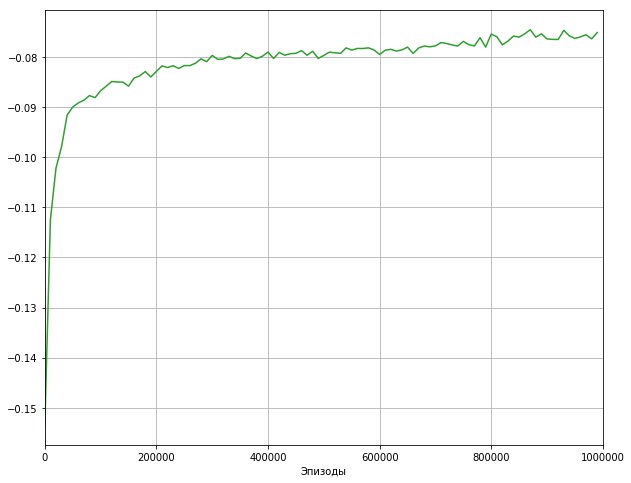

In [37]:
plot_results(results_mc_reshuffle_3, total_episodes, step=10000)

### Выводы
- Обе модели работают лучше базовой стратегии (брать карты, пока не наберем 19 очков)
- Модель Монте-Карло в данной задаче работает лучше, чем Q-learning.
- И удвоение, и подсчет карт улучшают результат, но обыграть казино не удалось
- Подбор гиперпараметров не дал большого эффекта. Видимо, надо было это делать как-то иначе